In [1]:
import pandas as pd
import numpy as np

import os.path

training_data = pd.read_parquet(os.path.join("data", "training.parquet"))

In [2]:
training_data.sample(10)

,Category,Text
13005,comp.sys.ibm.pc.hardware,Maybe I should have been clearer. I have a In...
17594,soc.religion.christian,"*******\n******* This is somewhat long, but p..."
17076,soc.religion.christian,In article <Apr.19.05.14.21.1993.29291@athos.r...
1053,rec.autos,In article <C5JnHA.8IB@murdoch.acc.Virginia.ED...
5745,comp.os.ms-windows.misc,In article <93122.134439ZHAO@auvm.american.edu...
10211,rec.motorcycles,In article <jburney.734756216@hydra.nodc.noaa....
3923,alt.atheism,kevin@rotag.mi.org (Kevin Darcy) writes:\n>In ...
8644,sci.med,From article <1993Apr22.233001.13436@vax.oxfor...
16165,sci.space,In <1rs0au$an6@access.digex.net> prb@access.di...
17775,soc.religion.christian,[Several people were involved in trying to fig...


In [3]:
import cloudpickle as cp
feature_pipeline = cp.load(open('feature_pipeline.sav', 'rb'))

In [4]:
training_vecs = feature_pipeline.fit_transform(training_data["Text"])

In [5]:
from xgboost import XGBClassifier

In [6]:
#xgb_model = XGBClassifier(tree_method='hist', n_estimators=128, max_depth = 4)

In [7]:
%%time

XGB_TREE_METHOD='hist'
xgb = XGBClassifier(tree_method=XGB_TREE_METHOD, 
                    # num_parallel_tree=16, 
                    n_estimators=100, 
                    max_depth=3, 
                    colsample_bynode=0.3, 
                    colsample_bytree=0.3, 
                    subsample=1, 
                    reg_alpha=1)

xgb.fit(training_vecs, training_data["Category"])

CPU times: user 5min 46s, sys: 18 s, total: 6min 4s
Wall time: 57.3 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.3, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=1,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

In [8]:
xgb.score(training_vecs, training_data["Category"])

0.8830572883057288

In [9]:
testing_data = pd.read_parquet(os.path.join("data", "testing.parquet"))
testing_vecs=feature_pipeline.transform(testing_data["Text"])
xgb.score(testing_vecs, testing_data["Category"])

0.721599464614355

In [10]:
from mlworkflows import plot

df, chart =plot.confusion_matrix(testing_data["Category"], xgb.predict(testing_vecs))

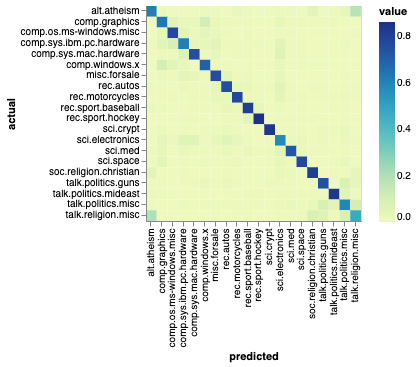

In [11]:
chart

In [14]:
from sklearn.metrics import classification_report
print(classification_report(testing_data["Category"], xgb.predict(testing_vecs)))

                          precision    recall  f1-score   support

             alt.atheism       0.62      0.61      0.61       284
           comp.graphics       0.60      0.63      0.61       303
 comp.os.ms-windows.misc       0.76      0.77      0.77       293
comp.sys.ibm.pc.hardware       0.62      0.61      0.62       303
   comp.sys.mac.hardware       0.76      0.76      0.76       286
          comp.windows.x       0.67      0.69      0.68       280
            misc.forsale       0.71      0.76      0.74       305
               rec.autos       0.70      0.76      0.73       300
         rec.motorcycles       0.79      0.78      0.78       317
      rec.sport.baseball       0.80      0.81      0.80       291
        rec.sport.hockey       0.89      0.86      0.88       310
               sci.crypt       0.92      0.84      0.88       303
         sci.electronics       0.51      0.58      0.54       274
                 sci.med       0.79      0.72      0.76       314
         

In [ ]:
from mlworkflows import util

util.serialize_to(xgb, "model.sav")